In [1]:
import mlflow
from mlflow.tracking.client import MlflowClient
from pyspark.sql import SQLContext
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.mllib.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from matplotlib import pyplot as plt
import numpy as np
from pyspark.sql import Row
from pyspark.rdd import RDD

spark = SparkSession.builder.appName('Project').getOrCreate()

store_sales=spark.read.csv("store_sales.tbl", inferSchema = True, header = True, sep = '|')
items=spark.read.csv("items.tbl", inferSchema = True, header = True, sep = '|')

store_sales.createTempView('store_sales')
items.createTempView('items')

q="SELECT ss.ss_customer_id AS cid, count(CASE WHEN i.i_class_id=1  THEN 1 ELSE NULL END) AS id1,count(CASE WHEN i.i_class_id=3  THEN 1 ELSE NULL END) AS id3,count(CASE WHEN i.i_class_id=5  THEN 1 ELSE NULL END) AS id5,count(CASE WHEN i.i_class_id=7  THEN 1 ELSE NULL END) AS id7, count(CASE WHEN i.i_class_id=9  THEN 1 ELSE NULL END) AS id9,count(CASE WHEN i.i_class_id=11 THEN 1 ELSE NULL END) AS id11,count(CASE WHEN i.i_class_id=13 THEN 1 ELSE NULL END) AS id13,count(CASE WHEN i.i_class_id=15 THEN 1 ELSE NULL END) AS id15,count(CASE WHEN i.i_class_id=2  THEN 1 ELSE NULL END) AS id2,count(CASE WHEN i.i_class_id=4  THEN 1 ELSE NULL END) AS id4,count(CASE WHEN i.i_class_id=6  THEN 1 ELSE NULL END) AS id6,count(CASE WHEN i.i_class_id=12 THEN 1 ELSE NULL END) AS id12, count(CASE WHEN i.i_class_id=8  THEN 1 ELSE NULL END) AS id8,count(CASE WHEN i.i_class_id=10 THEN 1 ELSE NULL END) AS id10,count(CASE WHEN i.i_class_id=14 THEN 1 ELSE NULL END) AS id14,count(CASE WHEN i.i_class_id=16 THEN 1 ELSE NULL END) AS id16 FROM store_sales ss INNER JOIN items i ON ss.ss_item_id = i.i_item_id WHERE i.i_category_name IN ('cat#01','cat#02','cat#03','cat#04','cat#05','cat#06','cat#07','cat#08','cat#09','cat#10','cat#11','cat#12','cat#013','cat#14','cat#15') AND ss.ss_customer_id IS NOT NULL GROUP BY ss.ss_customer_id HAVING count(ss.ss_item_id) > 3"

df = spark.sql(q)


assembler = VectorAssembler(inputCols=["cid", "id1", "id2", "id3", "id4", "id5", "id6", "id7", "id8", "id9", "id10"],outputCol ="features")

vd = assembler.transform(df)
cost = list()

for k in range (2,15):

    kmeans =    KMeans().setK(k).setFeaturesCol('features').setPredictionCol('prediction')

    model = kmeans.fit(vd)
    predictions = model.transform(vd)
    evaluator = ClusteringEvaluator()
    silhouette = evaluator.evaluate(predictions)

    cost.append(silhouette)

    print(cost)

centers = model.clusterCenters()

print("Cluster Centers: ")
for center in centers:
    print(center)

# Evaluate clustering by computing Silhouette score

print("Silhouette with squared euclidean distance = " + str(silhouette))

with mlflow.start_run():
    for center in centers:
        mlflow.log_metric("Cluster_Centers", all(center), step=all(center))
mlflow.log_metric("Silhouette_with_squared_euclidean_distance", silhouette)

kIdx = np.argmax(cost)
fig = plt.figure(1)
fig, ax = plt.subplots()
plt.plot(range (2,15), cost, 'b*-')
plt.plot(range (2,15)[kIdx], cost[kIdx], marker = 'o', markeredgecolor = 'r')
plt.xlim(1, plt.xlim()[1])
plt.xlabel('Number of cluster')
plt.ylabel('Silhouette coefficient')
plt.title('Silhouette for K-Means clustering')
plt.show()

	

/home/liuba/anaconda3/lib/python3.7/site-packages/py4j/java_collections.py:13: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import (
/home/liuba/anaconda3/lib/python3.7/site-packages/pyspark/resultiterable.py:23: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  class ResultIterable(collections.Iterable):


[0.7889317075062438]
[0.7889317075062438, 0.7514847853591848]
[0.7889317075062438, 0.7514847853591848, 0.7338088142714083]
[0.7889317075062438, 0.7514847853591848, 0.7338088142714083, 0.7240653581288485]
[0.7889317075062438, 0.7514847853591848, 0.7338088142714083, 0.7240653581288485, 0.7132588737268051]
[0.7889317075062438, 0.7514847853591848, 0.7338088142714083, 0.7240653581288485, 0.7132588737268051, 0.7096103940730919]
[0.7889317075062438, 0.7514847853591848, 0.7338088142714083, 0.7240653581288485, 0.7132588737268051, 0.7096103940730919, 0.7043503575891934]
[0.7889317075062438, 0.7514847853591848, 0.7338088142714083, 0.7240653581288485, 0.7132588737268051, 0.7096103940730919, 0.7043503575891934, 0.7052622085156856]
[0.7889317075062438, 0.7514847853591848, 0.7338088142714083, 0.7240653581288485, 0.7132588737268051, 0.7096103940730919, 0.7043503575891934, 0.7052622085156856, 0.701440108222692]
[0.7889317075062438, 0.7514847853591848, 0.7338088142714083, 0.7240653581288485, 0.713258873

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 1 Axes>

TypeError: only integer scalar arrays can be converted to a scalar index

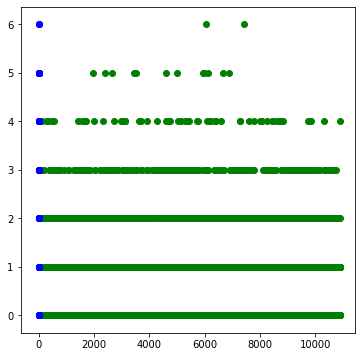

In [15]:
# Run local implementation of kmeans
km = KMeans().setK(2)
vd1 = assembler.transform(df)
km.fit(vd1)
vd_panda = vd1.toPandas()
fig, ax = plt.subplots(figsize=(6, 6))
plt.scatter(vd_panda.iloc[:, 0], vd_panda.iloc[:, 1],
	            c='green', label='cluster 1')
plt.scatter(vd_panda.iloc[:, 1], vd_panda.iloc[:, 1],
	            c='blue', label='cluster 2')
for i in centers:
    plt.scatter(centers[i], color=colmap[i])
plt.xlim(0, 80)
plt.ylim(0, 80)
plt.xlabel('Eruption time in mins')
plt.ylabel('Waiting time to next eruption')
plt.title('Visualization of clustered data', fontweight='bold')
ax.set_aspect('equal');

AnalysisException: 'Table or view not found: store_sales;'

In [ ]:
items.show()

In [18]:
q1="drop view items"

In [19]:
df = spark.sql(q1)

In [7]:
store_sales.createTempView('store_sales')

In [8]:
items.createTempView('items')

In [9]:
q="SELECT ss.ss_customer_id AS cid, count(CASE WHEN i.i_class_id=1  THEN 1 ELSE NULL END) AS id1,count(CASE WHEN i.i_class_id=3  THEN 1 ELSE NULL END) AS id3,count(CASE WHEN i.i_class_id=5  THEN 1 ELSE NULL END) AS id5,count(CASE WHEN i.i_class_id=7  THEN 1 ELSE NULL END) AS id7, count(CASE WHEN i.i_class_id=9  THEN 1 ELSE NULL END) AS id9,count(CASE WHEN i.i_class_id=11 THEN 1 ELSE NULL END) AS id11,count(CASE WHEN i.i_class_id=13 THEN 1 ELSE NULL END) AS id13,count(CASE WHEN i.i_class_id=15 THEN 1 ELSE NULL END) AS id15,count(CASE WHEN i.i_class_id=2  THEN 1 ELSE NULL END) AS id2,count(CASE WHEN i.i_class_id=4  THEN 1 ELSE NULL END) AS id4,count(CASE WHEN i.i_class_id=6  THEN 1 ELSE NULL END) AS id6,count(CASE WHEN i.i_class_id=12 THEN 1 ELSE NULL END) AS id12, count(CASE WHEN i.i_class_id=8  THEN 1 ELSE NULL END) AS id8,count(CASE WHEN i.i_class_id=10 THEN 1 ELSE NULL END) AS id10,count(CASE WHEN i.i_class_id=14 THEN 1 ELSE NULL END) AS id14,count(CASE WHEN i.i_class_id=16 THEN 1 ELSE NULL END) AS id16 FROM store_sales ss INNER JOIN items i ON ss.ss_item_id = i.i_item_id WHERE i.i_category_name IN ('cat#01','cat#02','cat#03','cat#04','cat#05','cat#06','cat#07','cat#08','cat#09','cat#10','cat#11','cat#12','cat#013','cat#14','cat#15') AND ss.ss_customer_id IS NOT NULL GROUP BY ss.ss_customer_id HAVING count(ss.ss_item_id) > 3"

In [10]:
df = spark.sql(q)

In [40]:
assembler = VectorAssembler(inputCols=["cid", "id1", "id2", "id3", "id4", "id5", "id6", "id7", "id8", "id9", "id10"],outputCol ="features")

In [41]:
vd = assembler.transform(df)

In [48]:
kmeans = KMeans().setK(8).setFeaturesCol('features').setPredictionCol("prediction")

In [49]:
model = kmeans.fit(vd)

In [50]:
centers = model.clusterCenters()

In [51]:
print("Cluster Centers: ")
for center in centers:
    print(center)

Cluster Centers: 
[6.61669841e+03 7.77777778e-01 2.57301587e+00 2.34285714e+00
 9.23809524e-01 2.25079365e+00 1.01746032e+00 2.32063492e+00
 1.46190476e+00 1.38095238e+00 1.63015873e+00]
[8.03439276e+02 7.55813953e-01 2.67183463e+00 2.36304910e+00
 9.41860465e-01 2.39018088e+00 9.79328165e-01 2.43540052e+00
 1.40956072e+00 1.36304910e+00 1.78294574e+00]
[2.38282442e+03 8.12071331e-01 2.62551440e+00 2.43209877e+00
 8.88888889e-01 2.34979424e+00 1.10562414e+00 2.44581619e+00
 1.42935528e+00 1.41152263e+00 1.83539095e+00]
[9.11895645e+03 6.93379791e-01 2.69163763e+00 2.56097561e+00
 9.96515679e-01 2.45296167e+00 1.02787456e+00 2.46341463e+00
 1.46515679e+00 1.34320557e+00 1.81881533e+00]
[5.27243223e+03 8.88554217e-01 2.61144578e+00 2.44728916e+00
 1.03162651e+00 2.40361446e+00 1.07379518e+00 2.46084337e+00
 1.56325301e+00 1.39759036e+00 1.83584337e+00]
[1.03059487e+04 7.04424779e-01 2.57522124e+00 2.27964602e+00
 9.32743363e-01 2.22654867e+00 1.04247788e+00 2.45840708e+00
 1.49026549e+00

In [52]:
import matplotlib.pyplot as plt

In [53]:
from pyspark.ml.evaluation import ClusteringEvaluator
evaluator = ClusteringEvaluator()
predictions = model.transform(vd)

silhouette = evaluator.evaluate(predictions)

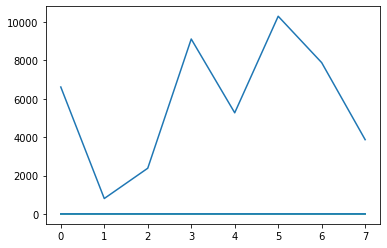

In [54]:
plt.plot(centers)

(array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]),
 array([0.20563099, 0.30563099, 0.40563099, 0.50563099, 0.60563099,
        0.70563099, 0.80563099, 0.90563099, 1.00563099, 1.10563099,
        1.20563099]),
 <a list of 10 Patch objects>)

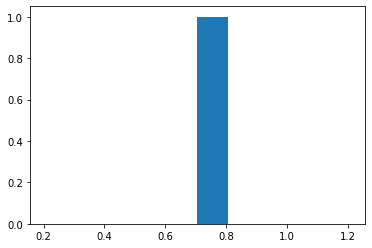

In [56]:
plt.hist(silhouette)

In [60]:
import numpy as np
n=3
centers,silhouette=np.arange(1,n)